In [333]:
import os
import re
import cv2 as cv
import numpy as np
from sklearn import model_selection as model_selection
import matplotlib.pyplot as plt
import scipy.spatial.distance as distance
from tqdm import tqdm
from sklearn.cluster import KMeans

## Task 1

In [183]:
TRAIN_PATH = "./train/classic/"

In [184]:
filenames = set([re.split("\.|_", filename)[0] for filename in os.listdir(TRAIN_PATH) if os.path.isfile(os.path.join(TRAIN_PATH, filename))])
filenames = sorted(list(filenames), key=lambda x: int(x))
print(filenames)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50']


In [185]:
def show_image_opencv(image, window_name="window", timeout=0):
    cv.imshow(window_name, np.uint8(image))
    cv.waitKey(timeout)
    cv.destroyAllWindows()

In [186]:
def show_image_pyplot(image):
    if len(image.shape) == 3:
        plt.imshow(image[:, :, [2, 1, 0]])
    else:
        plt.imshow(image, cmap="gray")
    plt.show()

In [187]:
def resize_image(image, d_width, inter=cv.INTER_LANCZOS4):
    height, width = image.shape[:2]
    d_height = int(height * d_width / width)
    return cv.resize(image, dsize=(d_width, d_height), interpolation=inter)

In [188]:
all_images = [cv.imread(os.path.join(TRAIN_PATH, f"{filename}.jpg")) for filename in filenames]
all_gt = []
for filename in filenames:
    with open(os.path.join(TRAIN_PATH, f"{filename}_gt.txt")) as f:
        all_gt.append(f.read())

assert(len(all_images) == len(all_gt))
print(f"Loaded {len(all_images)} images")

Loaded 50 images


xoxxoxooo
xoxoxoooo
oxooxooxx
xoxooooxo
ooxxooooo
oooxxxxoo
xoooxooxx
ooooooooo
oxoxoxxox


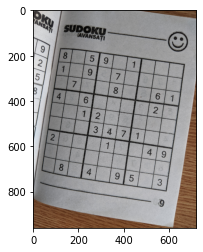

In [189]:
all_images = [resize_image(image, 720) for image in all_images]
print(all_gt[4])
show_image_pyplot(all_images[4])

In [22]:
train_images, dev_images, train_gt, dev_gt = model_selection.train_test_split(all_images, all_gt, test_size=0.2, random_state=42)

oxooooxoo
xooxoxxxo
ooooxooxx
oxxxooooo
oxxoxooxx
oooooxooo
xooooxxox
ooooxoxoo
oxoooooxo


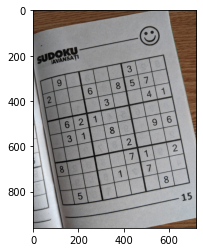

In [190]:
img = all_images[8].copy()
gt = all_gt[8]

print(gt)
show_image_pyplot(img)

In [191]:
def remove_light_grays(img):
    img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    mask = cv.inRange(img_hsv, (0, 0, 100), (255, 20, 255))
    res = img.copy()
    res[np.where(mask)] = (255, 255, 255)
    return res

In [391]:
def preprocess_binary_image(image, kernel_size=(7, 7)):
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    else:
        gray = image
    applied_blur = cv.GaussianBlur(gray, kernel_size, 0)
    thresholded = cv.adaptiveThreshold(applied_blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, kernel_size[0], 2)
    inverted = cv.bitwise_not(thresholded)
    median_blur = cv.medianBlur(inverted, 5)
    return median_blur

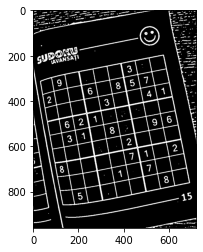

In [193]:
preprocessed_img = preprocess_binary_image(img)
show_image_pyplot(preprocessed_img)

In [194]:
def dilate_image(binary_img, kernel_size=3, iterations=1):
    kernel = np.ones((kernel_size, kernel_size), dtype=np.uint8)
    return cv.dilate(binary_img, kernel, iterations=iterations)

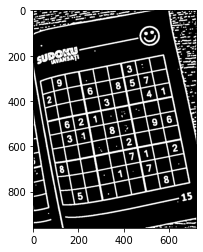

In [195]:
dilated_img = dilate_image(preprocessed_img)
show_image_pyplot(dilated_img)

In [196]:
def find_largest_polygon(binary_img):
    polygons, _ = cv.findContours(binary_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    polygon = max(polygons, key=lambda p: cv.contourArea(p))
    approx_poly = polygon # cv.approxPolyDP(polygon, 0.2 * cv.arcLength(polygon, True), True)
    return approx_poly

In [197]:
sudoku_square = find_largest_polygon(dilated_img)

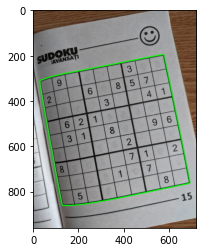

In [198]:
found_contour_img = cv.drawContours(img.copy(), [sudoku_square], 0, (0,255,0), 3)
show_image_pyplot(found_contour_img)

In [199]:
def get_corners(polygon, eps=10):
    def get_max_vertex(cmp):
        return max([(vertex[0][0], vertex[0][1]) for vertex in polygon], key=cmp)

    tr = get_max_vertex(lambda p: p[0] - p[1])
    tl = get_max_vertex(lambda p: -p[0] - p[1])
    bl = get_max_vertex(lambda p: -p[0] + p[1])
    br = get_max_vertex(lambda p: p[0] + p[1])

    return (tr, tl, bl, br)

In [200]:
tr, tl, bl, br = get_corners(sudoku_square)

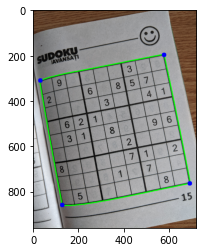

In [201]:
for corner in [tr, tl, bl, br]:
    found_contour_img = cv.circle(found_contour_img, (corner[0], corner[1]), 10, (255, 0, 0), thickness=-1)
show_image_pyplot(found_contour_img)

In [202]:
def compute_longest_side(tr, tl, bl, br):
    return max(
        distance.euclidean(tr, tl),
        distance.euclidean(bl, tl),
        distance.euclidean(br, bl),
        distance.euclidean(br, tr),
    )

In [34]:
side_len = compute_longest_side(tr, tl, bl, br)
side_len

575.0286949361745

In [393]:
def warp_image(img, corners, side_len=None):
    tr, tl, bl, br = corners
    edge_len = side_len if side_len is not None else int(compute_longest_side(tr, tl, bl, br))

    transform_matrix = cv.getPerspectiveTransform(
        np.array([tl, tr, br, bl], dtype=np.float32),
        np.array([[0, 0], [edge_len - 1, 0], [edge_len - 1, edge_len - 1], [0, edge_len - 1]], dtype=np.float32)
    )

    return cv.warpPerspective(img, transform_matrix, (edge_len, edge_len))

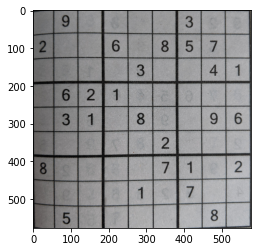

In [204]:
warped = warp_image(img, corners=(tr, tl, bl, br))
show_image_pyplot(warped)

In [246]:
class CompletedBoxClassifier:
    def __init__(self, thresh, mode="var"):
        self.thresh = thresh
        self.mode = mode

    def __call__(self, box):
        if self.mode == "var":
            return np.var(box) > self.thresh
        elif self.mode == "mean":
            return np.mean(box) > self.thresh
        # box_copy = box.copy()
        # height, width = box_copy.shape

        # max_area = 0
        # digit_x, digit_y = None, None
        # for x in range(width):
        #     for y in range(height):
        #         if box_copy[y, x] == 255:
        #             area = cv.floodFill(box_copy, None, (x, y), 100)[0]
        #             if area > max_area:
        #                 max_area = area
        #                 digit_x, digit_y = x, y

        # if max_area == 0:
        #     return False

        # cv.floodFill(box_copy, None, (digit_x, digit_y), 255)
        # min_x, max_x = width, 0
        # min_y, max_y = height, 0
        # for x in range(width):
        #     for y in range(height):
        #         if box_copy[y, x] == 255:
        #             min_x = min(min_x, x)
        #             max_x = max(max_x, x)
        #             min_y = min(min_y, y)
        #             max_y = max(max_y, y)

        # # s = set([])
        # # for x in range(width):
        # #     for y in range(height):
        # #         s.add(box[y, x])
        # # print(s) 
        
        # # print((max_x - min_x) , (max_y - min_y) ,  width , height)

        # return (max_x - min_x) * (max_y - min_y) > self.thresh * width * height

In [206]:
def classify_boxes(img, classifier, debug=False, margin_pct=0.20):
    box_len = int(img.shape[0] / 9)

    return_string = ""

    fig = plt.figure(figsize=(9, 9))
    fig.tight_layout()
    for i in range(9):
        for j in range(9):
            box = img[i * box_len:(i + 1) * box_len - 1, j * box_len:(j + 1) * box_len - 1].copy()
            margin = int(box_len * margin_pct)
            box = box[margin:-margin, margin:-margin]

            predicted = classifier(box)

            ax = fig.add_subplot(9, 9, i * 9 + j + 1)
            if predicted:
                plt.imshow(box)
                return_string += "x"
            else:
                plt.imshow(box, cmap="gray")
                return_string += "o"
            plt.axis("off")
        return_string += "\n"
    
    if debug:
        plt.show()
    else:
        fig.clear()
        plt.close(fig)

    return return_string[:-1]

In [207]:
def make_prediction_task1(img, classifier, debug=False):
    if debug:
        show_image_pyplot(img)

    grays_removed = img.copy()
    # grays_removed = remove_light_grays(img)
    # if debug:
    #     show_image_pyplot(grays_removed)
    # plt.clf()
    
    preprocessed_img = preprocess_binary_image(grays_removed)
    if debug:
        show_image_pyplot(preprocessed_img)
    plt.clf()

    dilated_img = dilate_image(preprocessed_img)
    if debug:
        show_image_pyplot(dilated_img)
    plt.clf()

    sudoku_square = find_largest_polygon(dilated_img)
    found_contour_img = cv.drawContours(img, [sudoku_square], 0, (0,255,0), 3)
    tr, tl, bl, br = get_corners(sudoku_square)
    for corner in [tr, tl, bl, br]:
        found_contour_img = cv.circle(found_contour_img, (corner[0], corner[1]), 10, (255, 0, 0), thickness=-1)
    if debug:
        show_image_pyplot(found_contour_img)
    plt.clf()

    warped = warp_image(grays_removed, corners=(tr, tl, bl, br))
    warped_gray = cv.cvtColor(warped, cv.COLOR_BGR2GRAY)
    if debug:
        show_image_pyplot(warped_gray)
    plt.clf()

    predict_str = classify_boxes(warped_gray, classifier, debug=debug)
    plt.clf()

    return predict_str

In [217]:
classifier = CompletedBoxClassifier(thresh=600)

In [218]:
acc = 0
missed = []
for i, (img, gt) in enumerate(tqdm(zip(all_images, all_gt), total=len(all_images))):
    predicted = make_prediction_task1(img.copy(), classifier)
    if predicted == gt:
        acc += 1
    else:
        missed.append(i)
print(f"\n\n{acc * 100 / len(all_images):.3f}%")
print(missed)

100%|██████████| 50/50 [04:05<00:00,  4.91s/it]

98.000%
[25]



<Figure size 432x288 with 0 Axes>

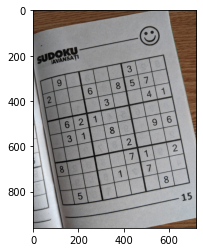

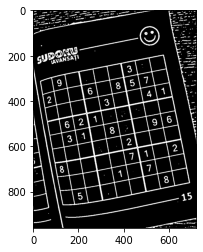

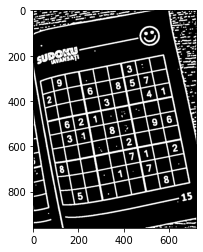

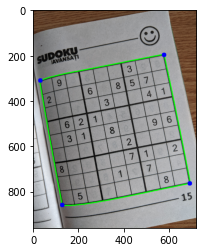

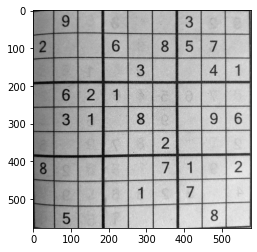

<Figure size 432x288 with 0 Axes>

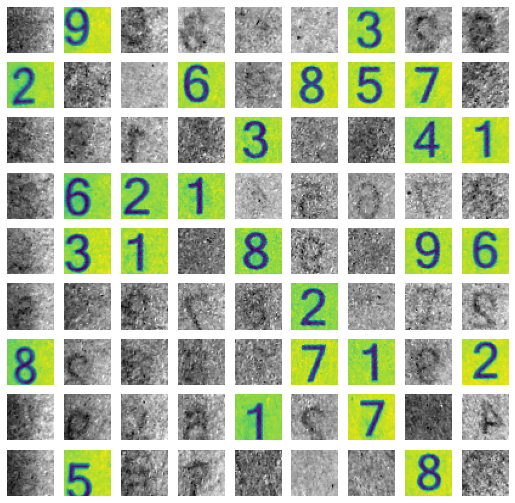

oxooooxoo
xooxoxxxo
ooooxooxx
oxxxooooo
oxxoxooxx
oooooxooo
xooooxxox
ooooxoxoo
oxoooooxo


<Figure size 432x288 with 0 Axes>

In [219]:
img = all_images[8].copy()
print(make_prediction_task1(img, classifier, debug=True))

## Task 2

In [220]:
TRAIN_PATH = "./train/jigsaw/"

In [221]:
filenames = set([re.split("\.|_", filename)[0] for filename in os.listdir(TRAIN_PATH) if os.path.isfile(os.path.join(TRAIN_PATH, filename))])
filenames = sorted(list(filenames), key=lambda x: int(x))
print(filenames)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40']


In [222]:
all_images = [cv.imread(os.path.join(TRAIN_PATH, f"{filename}.jpg")) for filename in filenames]
all_gt = []
for filename in filenames:
    with open(os.path.join(TRAIN_PATH, f"{filename}_gt.txt")) as f:
        all_gt.append(f.read())

assert(len(all_images) == len(all_gt))
print(f"Loaded {len(all_images)} images")

Loaded 40 images


1x1x2o2x2o3x3x3o3x
4o1o1x2o2x2o3x3o3o
4o4x1x1o2o2o2o3o3o
4o4o4o1o1o5x5o5o5o
6o4x4o7o1o8o8o5x5o
6o6o4o7x7o8o8o5o5o
6o6o9x9o7o7o8x8x5o
6o6o9o9o9x7o7x8o8o
6x6o9x9x9o9x7o7x8x


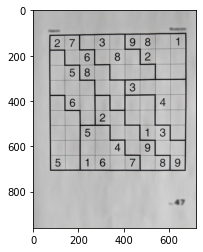

In [223]:
all_images = [resize_image(image, 720) for image in all_images]
print(all_gt[1])
show_image_pyplot(all_images[1])

ooooooxxo
xxooxoooo
oooooxooo
oooxooxxo
oooooooox
oxooxooxo
oxoxxoxoo
oooxoxxoo
oxoooxooo
111222233
111233333
112222334
144444444
555566666
557668866
557888899
577788999
777789999


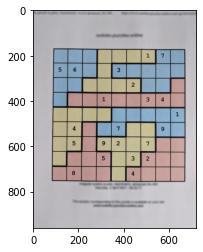

In [317]:
img = all_images[0].copy()
gt = all_gt[0]

gt_digit = "\n".join([line[1::2] for line in gt.split("\n")])
gt_zones = "\n".join([line[::2] for line in gt.split("\n")])

print(gt_digit)
print(gt_zones)
show_image_pyplot(img)

In [231]:
def has_color(img):
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    return np.mean(hsv[:, :, 1]) > 15

In [242]:
class CellBorders:
    def __init__(self, up=False, right=False, down=False, left=False):
        self.up = up
        self.right = right
        self.down = down
        self.left = left
    
    def __str__(self):
        res = ""
        if self.up:
            res += "U"
        if self.right:
            res += "R"
        if self.down:
            res += "D"
        if self.left:
            res += "L"
        if not res:
            res = "none"
        return res

    def __repr__(self):
        return str(self)


In [273]:
def classify_borders(binary_img, classifier, debug=False, margin_pct=0.10):
    box_len = int(binary_img.shape[0] / 9)

    borders = [[CellBorders() for i in range(9)] for j in range(9)]

    for i in range(9):
        for j in range(9):
            box = binary_img[i * box_len:(i + 1) * box_len - 1, j * box_len:(j + 1) * box_len - 1].copy()
            margin = int(box_len * margin_pct)

            # up
            box_margin = box[:margin, :]
            # show_image_pyplot(box)
            predicted = classifier(box_margin)
            if predicted:
                borders[i][j].up = True
                if i > 0:
                    borders[i - 1][j].down = True
            
            # right
            box_margin = box[:, -margin:]
            predicted = classifier(box_margin)
            if predicted:
                borders[i][j].right = True
                if j < 8:
                    borders[i][j + 1].left = True

            # down
            box_margin = box[-margin:, :]
            predicted = classifier(box_margin)
            if predicted:
                borders[i][j].down = True
                if i < 8:
                    borders[i + 1][j].up = True

            # left
            box_margin = box[:, :margin]
            predicted = classifier(box_margin)
            if predicted:
                borders[i][j].left = True
                if j > 0:
                    borders[i][j - 1].right = True
    
    if debug:
        print("\n".join(["\t".join([str(x) for x in line]) for line in borders]))

    return borders

In [277]:
def fill_regions(borders):
    zones = [[0] * 9 for _ in range(9)]
    def recursive_fill(i, j, val):
        if zones[i][j] != 0:
            return
        zones[i][j] = val
        if i > 0 and not borders[i][j].up:
            recursive_fill(i - 1, j, val)
        if i < 8 and not borders[i][j].down:
            recursive_fill(i + 1, j, val)
        if j > 0 and not borders[i][j].left:
            recursive_fill(i, j - 1, val)
        if j < 8 and not borders[i][j].right:
            recursive_fill(i, j + 1, val)
    
    curr = 0
    for i in range(9):
        for j in range(9):
            if zones[i][j] == 0:
                curr += 1
                recursive_fill(i, j, curr)
    
    return "\n".join(["".join([str(x) for x in line]) for line in zones])

In [376]:
def find_colored_zones(img, binary_img, num_colors=3, debug=False, margin_pct=0.15):
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    box_len = int(img.shape[0] / 9)
    colors = []

    fig = plt.figure(figsize=(9, 9))
    for i in range(9):
        for j in range(9):
            top = i * box_len
            bottom = (i + 1) * box_len
            left = j * box_len
            right = (j + 1) * box_len
            
            mean_color = np.array([0., 0., 0.])
            mean_hue = np.array([0.])
            cnt = 0
            for y in range(top, bottom):
                for x in range(left, right):
                    if binary_img[y, x] == 0:
                       mean_color += img[y, x]
                       mean_hue += hsv[y, x, 0]
                       cnt += 1
            mean_color = np.array(mean_color / cnt, dtype=np.uint8)
            mean_hue = mean_hue / cnt

            ax = fig.add_subplot(9, 9, i * 9 + j + 1)
            if predicted:
                plt.imshow([[mean_color[[2, 1, 0]]] * box_len] * box_len)
                plt.axis("off")

            colors.append(mean_hue)

    clusters = list(KMeans(n_clusters=num_colors, random_state=42).fit_predict(colors))
    if debug:
        print(clusters)
    zones = [[0] * 9 for _ in range(9)]
    for i in range(9):
        for j in range(9):
            zones[i][j] = clusters.pop(0) + 1
    
    def fill_conex_region(i, j, val):
        color = zones[i][j]
        zones[i][j] = -val
        for d_i, d_j in [[0, 1], [0, -1], [1, 0], [-1, 0]]:
            ni, nj = i + d_i, j + d_j
            if 0 > ni or ni > 8 or 0 > nj or nj > 8 or zones[ni][nj] != color:
                continue
            fill_conex_region(ni, nj, val)
    
    curr = 0
    for i in range(9):
        for j in range(9):
            if zones[i][j] < 0:
                continue
            curr += 1
            fill_conex_region(i, j, curr)
    
    ret_string = "\n".join(["".join([str(-x) for x in line]) for line in zones])
    if debug:
        plt.show()
        print(ret_string)
    else:
        fig.clear()
        plt.close(fig)

    return ret_string

In [287]:
def combine_predictions(pred_digits, pred_zones):
    res = ""
    for fst, snd in zip(pred_zones.split("\n"), pred_digits.split("\n")):
        for x, y in zip(fst, snd):
            res += x + y
        res += "\n"
    return res[:-1]

In [319]:
def make_prediction_task2_gray(warped, digit_classifier, border_classifier, debug=False):
    grays_removed = remove_light_grays(warped)
    grays_removed = cv.medianBlur(grays_removed, 5)
    if debug:
        show_image_pyplot(grays_removed)

    binary_warped = preprocess_binary_image(grays_removed, kernel_size=(3, 3)) # 5 for color
    if debug:
        show_image_pyplot(binary_warped)

    dilated_image = dilate_image(binary_warped, kernel_size=7)
    if debug:
        show_image_pyplot(dilated_image)

    gray_warped = cv.cvtColor(warped, cv.COLOR_BGR2GRAY)
    predicted_digits = classify_boxes(gray_warped, digit_classifier, debug=debug)

    borders = classify_borders(dilated_image, border_classifier, debug=debug, margin_pct=0.10)
    predicted_regions = fill_regions(borders)

    final_predictions = combine_predictions(predicted_digits, predicted_regions)
    if debug:
        print(final_predictions)
    
    return final_predictions

In [366]:
def make_prediction_task2_color(warped, digit_classifier, debug=False):
    binary_warped = preprocess_binary_image(warped, kernel_size=(5, 5))
    binary_warped = dilate_image(binary_warped, kernel_size=4)
    if debug:
        show_image_pyplot(binary_warped)

    gray_warped = cv.cvtColor(warped, cv.COLOR_BGR2GRAY)
    predicted_digits = classify_boxes(gray_warped, digit_classifier, debug=debug)

    predicted_regions = find_colored_zones(warped, binary_warped, debug=debug)

    final_predictions = combine_predictions(predicted_digits, predicted_regions)
    if debug:
        print(final_predictions)
    
    return final_predictions

In [370]:
def make_prediction_task2(img, digit_classifier, border_classifier, debug=False):
    if debug:
        show_image_pyplot(img)

    preprocessed_img = preprocess_binary_image(img)
    if debug:
        show_image_pyplot(preprocessed_img)

    sudoku_square = find_largest_polygon(preprocessed_img)
    found_contour_img = cv.drawContours(img.copy(), [sudoku_square], 0, (0,255,0), 3)
    tr, tl, bl, br = get_corners(sudoku_square)
    for corner in [tr, tl, bl, br]:
        found_contour_img = cv.circle(found_contour_img, (corner[0], corner[1]), 10, (255, 0, 0), thickness=-1)
    if debug:
        show_image_pyplot(found_contour_img)

    warped = warp_image(img, corners=(tr, tl, bl, br))
    if debug:
        show_image_pyplot(warped)

    if has_color(warped):
        return make_prediction_task2_color(warped, digit_classifier, debug=debug)
    else:
        return make_prediction_task2_gray(warped, digit_classifier, border_classifier, debug=debug)

In [363]:
digit_classifier = CompletedBoxClassifier(thresh=600, mode="var")
border_classifier = CompletedBoxClassifier(thresh=100, mode="mean")

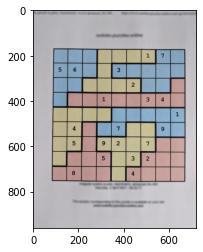

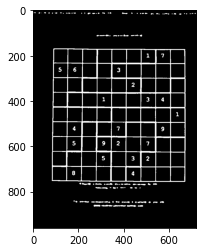

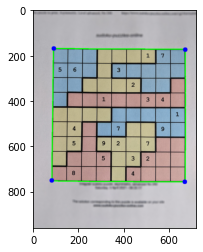

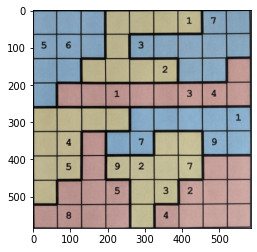

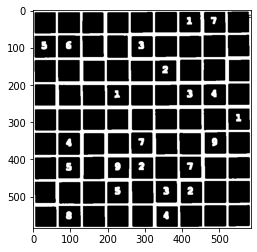

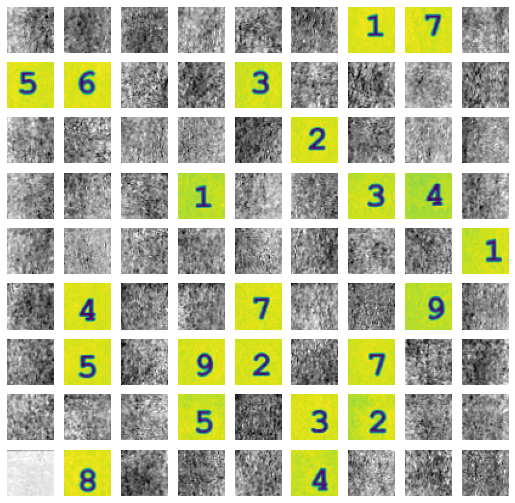

[1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 2, 1, 1, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2]


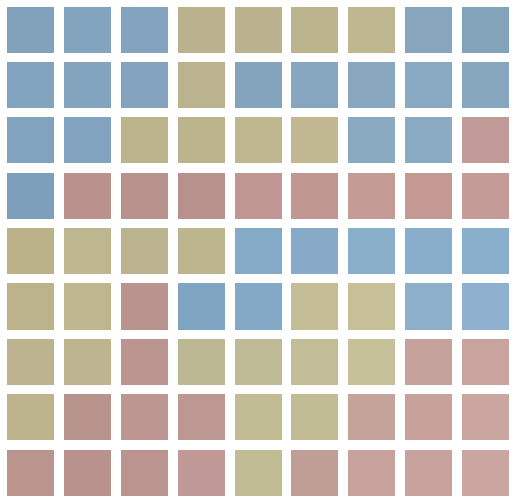

111222233
111233333
112222334
144444444
555566666
557668866
557888899
577788999
777789999
1o1o1o2o2o2o2x3x3o
1x1x1o2o3x3o3o3o3o
1o1o2o2o2o2x3o3o4o
1o4o4o4x4o4o4x4x4o
5o5o5o5o6o6o6o6o6x
5o5x7o6o6x8o8o6x6o
5o5x7o8x8x8o8x9o9o
5o7o7o7x8o8x9x9o9o
7o7x7o7o8o9x9o9o9o


True

In [379]:
TEST_IDX = 0
make_prediction_task2(all_images[TEST_IDX].copy(), digit_classifier, border_classifier, debug=True) == all_gt[TEST_IDX]

In [380]:
acc = 0
missed = []
for i, (img, gt) in enumerate(tqdm(zip(all_images, all_gt), total=len(all_images))):
    predicted = make_prediction_task2(img.copy(), digit_classifier, border_classifier)
    if predicted == gt:
        acc += 1
    else:
        missed.append(i)
print(f"\n\n{acc * 100 / len(all_images):.3f}%")
print(missed)

100%|██████████| 40/40 [05:54<00:00,  8.87s/it]

100.000%
[]



## Task 3

In [532]:
TRAIN_PATH = "./train/cube/"

In [533]:
filenames = set([re.split("\.|_", filename)[0] for filename in os.listdir(TRAIN_PATH) if os.path.isfile(os.path.join(TRAIN_PATH, filename))])
filenames.remove("template")
filenames = sorted(list(filenames), key=lambda x: int(x))
print(filenames)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']


In [534]:
all_images = [cv.imread(os.path.join(TRAIN_PATH, f"{filename}.jpg"), cv.IMREAD_GRAYSCALE) for filename in filenames]
all_gt = []
for filename in filenames:
    with open(os.path.join(TRAIN_PATH, f"{filename}_gt.txt")) as f:
        all_gt.append(f.read())

assert(len(all_images) == len(all_gt))
print(f"Loaded {len(all_images)} images")

Loaded 10 images


846712593
127935468
359684271
612573849
935468127
784291356
463827915
598146732
271359684

271359684 425679183
359684271 183452976
684271359 967831452
827915463 318245769
915463827 796183524
463827915 542967318
732598146 679318245
598146732 254796831
146732598 831524697


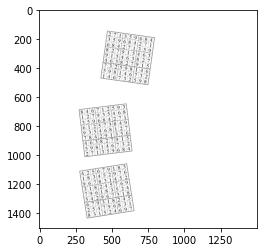

In [535]:
# all_images = [resize_image(image, 720) for image in all_images]
print(all_gt[4])
show_image_pyplot(all_images[4])

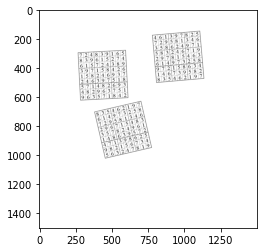

In [536]:
img = all_images[0].copy()
gt = all_gt[0]
show_image_pyplot(img)

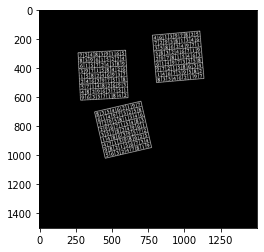

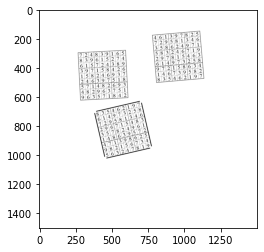

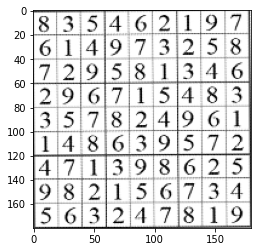

In [537]:
preprocessed_img = preprocess_binary_image(img)
show_image_pyplot(preprocessed_img)

sudoku_square = find_largest_polygon(preprocessed_img)
found_contour_img = cv.drawContours(img.copy(), [sudoku_square], 0, (0,255,0), 3)
tr, tl, bl, br = get_corners(sudoku_square)
for corner in [tr, tl, bl, br]:
    found_contour_img = cv.circle(found_contour_img, (corner[0], corner[1]), 10, (255, 0, 0), thickness=-1)
show_image_pyplot(found_contour_img)

warped = warp_image(img, corners=(tr, tl, bl, br), side_len=180)
show_image_pyplot(warped)

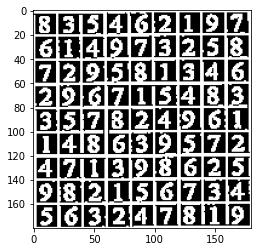

In [538]:
applied_blur = cv.GaussianBlur(warped, (3, 3), 0)
thresholded = cv.adaptiveThreshold(applied_blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 3, 2)
inverted = cv.bitwise_not(thresholded)
warped_binary = dilate_image(inverted, 2)
show_image_pyplot(warped_binary)

In [539]:
def get_digit_cell(img, row, col, margin_pct=0.15):
    box_len = int(img.shape[0] / 9)
    margin = int(box_len * margin_pct)
    box = img[row * box_len:(row + 1) * box_len, col * box_len:(col + 1) * box_len].copy()
    return box[margin:-margin, margin:-margin]

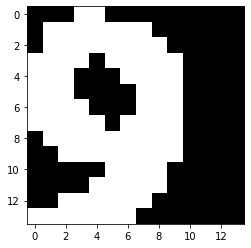

In [552]:
cells = [
    get_digit_cell(warped_binary, 0, 6),
    get_digit_cell(warped_binary, 0, 5),
    get_digit_cell(warped_binary, 4, 0),
    get_digit_cell(warped_binary, 0, 3),
    get_digit_cell(warped_binary, 4, 1),
    get_digit_cell(warped_binary, 0, 4),
    get_digit_cell(warped_binary, 0, 8),
    get_digit_cell(warped_binary, 1, 8),
    get_digit_cell(warped_binary, 0, 7),
]

show_image_pyplot(cells[8])

In [553]:
def count_difference(img1, img2, delta_x, delta_y):
    cnt = 0
    for y in range(img1.shape[0]):
        for x in range(img1.shape[1]):
            nx = x + delta_x
            ny = y + delta_y
            if 0 > nx or nx >= img2.shape[1] or 0 > ny or ny >= img2.shape[0]:
                if img1[y, x] == 255:
                    cnt += 1
                continue
            if img1[y, x] != img2[ny, nx]:
                cnt += 1
    return cnt

In [554]:
def find_best_match(img, template, max_range=4):
    best_cnt = float("inf")
    for delta_x in range(-max_range, max_range + 1):
        for delta_y in range(-max_range, max_range + 1):
            cnt = count_difference(img, template, delta_x, delta_y)
            best_cnt = min(best_cnt, cnt)
    return best_cnt

In [555]:
def find_best_template(img, templates, max_range=4):
    best_cnt = float("inf")
    best_template = None
    for i, template in enumerate(templates):
        cnt = find_best_match(img, template, max_range)
        if cnt < best_cnt:
            best_cnt = cnt
            best_template = i
    return best_template

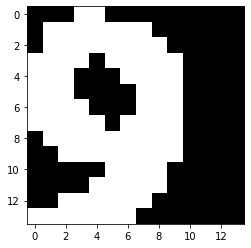

In [556]:
cell = get_digit_cell(warped_binary, 5, 5)
best_template = cells[find_best_template(cell, cells)]
show_image_pyplot(best_template)

In [557]:
res_str = ""
for i in range(9):
    for j in range(9):
        cell = get_digit_cell(warped_binary, i, j)
        digit = find_best_template(cell, cells) + 1
        res_str += str(digit)
    res_str += "\n"
res_str = res_str[:-1]
print(res_str)

835462197
614973258
729581346
296715483
357824961
148639572
471398625
982156734
563247819


In [558]:
for i, cell in enumerate(cells):
    cv.imwrite(f"./digit_db/{i+1}.bmp", cell)

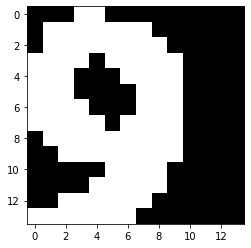

True

In [559]:
cell = cv.imread("./digit_db/9.bmp", cv.IMREAD_GRAYSCALE)
show_image_pyplot(cell)
np.all((cell == 0) | (cell == 255))

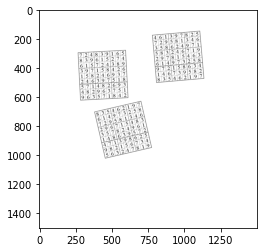

In [560]:
img = all_images[0].copy()
gt = all_gt[0]
show_image_pyplot(img)

In [500]:
def find_largest_polygons(binary_img, num=3):
    polygons, _ = cv.findContours(binary_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    polygons = sorted(polygons, key=lambda p: -cv.contourArea(p))
    return polygons[:num]

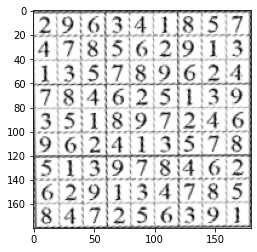

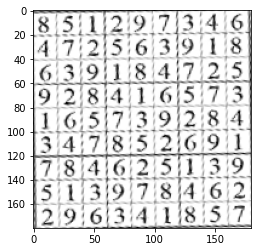

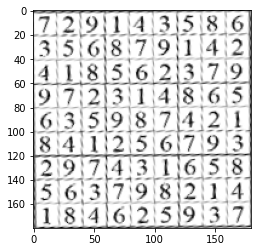

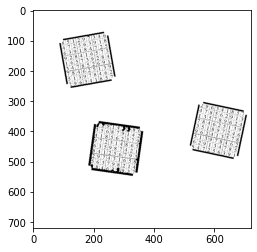

In [501]:
preprocessed_img = preprocess_binary_image(img)

found_contour_img = img.copy()
warped_imgs = []
for contour in find_largest_polygons(preprocessed_img):
    found_contour_img = cv.drawContours(found_contour_img, [contour], 0, (0,255,0), 3)
    tr, tl, bl, br = get_corners(contour)
    for corner in [tr, tl, bl, br]:
        found_contour_img = cv.circle(found_contour_img, (corner[0], corner[1]), 10, (255, 0, 0), thickness=-1)
    warped_imgs.append(warp_image(img, corners=(tr, tl, bl, br), side_len=180))
    show_image_pyplot(warped_imgs[-1])

show_image_pyplot(found_contour_img)

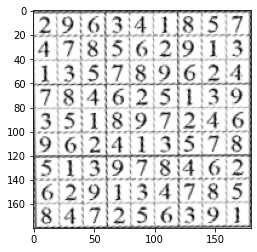

296341857
478562913
135789624
784625139
351897246
962413578
513978462
629134785
847256391


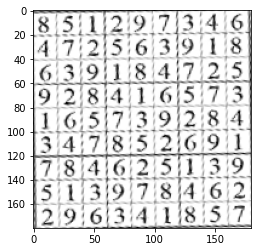

851297346
472563918
639184725
928416573
165739284
347852691
784625139
513978462
296341857


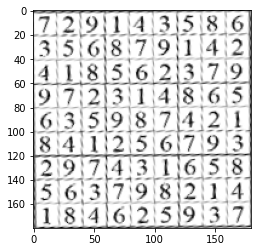

729143586
356879142
418562379
972314865
635987421
841256793
297431658
563798214
184625937


In [503]:
parsed_boards = []
for warped in warped_imgs:
    applied_blur = cv.GaussianBlur(warped, (3, 3), 0)
    thresholded = cv.adaptiveThreshold(applied_blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 3, 2)
    inverted = cv.bitwise_not(thresholded)
    warped_binary = dilate_image(inverted, 2)

    res_str = ""
    for i in range(9):
        for j in range(9):
            cell = get_digit_cell(warped_binary, i, j)
            digit = find_best_template(cell, cells) + 1
            res_str += str(digit)
        res_str += "\n"
    res_str = res_str[:-1]
    show_image_pyplot(warped)
    print(res_str)
    parsed_boards.append(res_str)

In [524]:
def find_order_of_boards(parsed_boards):
    for top in range(3):
        for front in range(3):
            if top == front or parsed_boards[top].split("\n")[-1] != parsed_boards[front].split("\n")[0]:
                continue
            for right in range(3):
                if right == top or right == front:
                    continue
                ok = True
                for i in range(9):
                    ok &= parsed_boards[top].split("\n")[i][-1] == parsed_boards[right].split("\n")[0][8 - i]
                    ok &= parsed_boards[front].split("\n")[i][-1] == parsed_boards[right].split("\n")[i][0]
                if ok:
                    return top, front, right
    return 0, 1, 2

In [513]:
top, front, right = find_order_of_boards(parsed_boards)
res_str = parsed_boards[top] + "\n\n"
for i in range(9):
    res_str += parsed_boards[front].split("\n")[i] + " " + parsed_boards[right].split("\n")[i] + "\n"
res_str = res_str[:-1]
print(res_str)
print(res_str == gt)

851297346
472563918
639184725
928416573
165739284
347852691
784625139
513978462
296341857

296341857 729143586
478562913 356879142
135789624 418562379
784625139 972314865
351897246 635987421
962413578 841256793
513978462 297431658
629134785 563798214
847256391 184625937
True


In [527]:
def make_prediction_task3(img, debug=False):
    preprocessed_img = preprocess_binary_image(img)
    if debug:
        show_image_pyplot(preprocessed_img)

    found_contour_img = img.copy()
    warped_imgs = []
    for contour in find_largest_polygons(preprocessed_img):
        found_contour_img = cv.drawContours(found_contour_img, [contour], 0, (0,255,0), 3)
        tr, tl, bl, br = get_corners(contour)
        # for corner in [tr, tl, bl, br]:
        #     found_contour_img = cv.circle(found_contour_img, (corner[0], corner[1]), 10, (255, 0, 0), thickness=-1)
        warped_imgs.append(warp_image(img, corners=(tr, tl, bl, br), side_len=180))

    if debug:
        show_image_pyplot(found_contour_img)

    parsed_boards = []
    for warped in warped_imgs:
        applied_blur = cv.GaussianBlur(warped, (3, 3), 0)
        thresholded = cv.adaptiveThreshold(applied_blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 3, 2)
        inverted = cv.bitwise_not(thresholded)
        warped_binary = dilate_image(inverted, 2)

        res_str = ""
        for i in range(9):
            for j in range(9):
                cell = get_digit_cell(warped_binary, i, j)
                digit = find_best_template(cell, cells) + 1
                res_str += str(digit)
            res_str += "\n"
        res_str = res_str[:-1]
        
        if debug:
            show_image_pyplot(warped)
            print(res_str)

        parsed_boards.append(res_str)
    
    top, front, right = find_order_of_boards(parsed_boards)
    res_str = parsed_boards[top] + "\n\n"
    for i in range(9):
        res_str += parsed_boards[front].split("\n")[i] + " " + parsed_boards[right].split("\n")[i] + "\n"
    res_str = res_str[:-1]

    return res_str

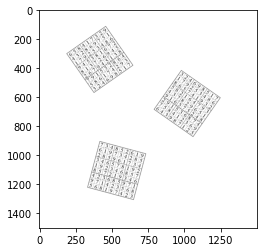

In [563]:
img = all_images[9].copy()
gt = all_gt[9]
show_image_pyplot(img)

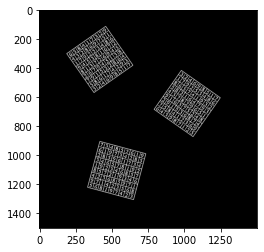

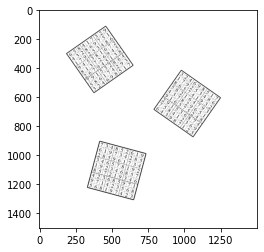

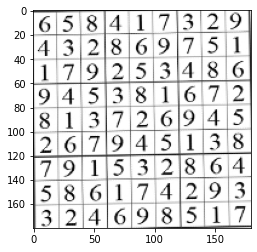

658417329
432869751
179253486
945381672
813726945
267945138
791532864
586174293
324698517


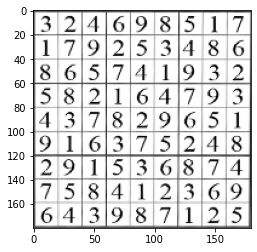

324698517
179253486
865741932
582164793
437829651
916375248
291536874
758412369
643987125


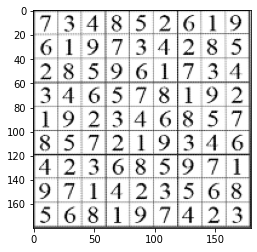

734852619
619734285
285961734
346578192
192346857
857219346
423685971
971423568
568197423
658417329
432869751
179253486
945381672
813726945
267945138
791532864
586174293
324698517

324698517 734852619
179253486 619734285
865741932 285961734
582164793 346578192
437829651 192346857
916375248 857219346
291536874 423685971
758412369 971423568
643987125 568197423


True

In [564]:
res_str = make_prediction_task3(img, debug=True)
print(res_str)
res_str == gt

In [565]:
acc = 0
missed = []
for i, (img, gt) in enumerate(tqdm(zip(all_images, all_gt), total=len(all_images))):
    predicted = make_prediction_task3(img.copy())
    if predicted == gt:
        acc += 1
    else:
        missed.append(i)
print(f"\n\n{acc * 100 / len(all_images):.3f}%")
print(missed)

100%|██████████| 10/10 [06:24<00:00, 38.47s/it]

100.000%
[]



In [566]:
def print_coords(event, x, y, flags, param):
    if event == cv.EVENT_LBUTTONDOWN:
        print(x, y)

In [567]:
template = cv.imread(os.path.join(TRAIN_PATH, "template.jpg"), cv.IMREAD_GRAYSCALE)
cv.namedWindow("Template")
cv.setMouseCallback("Template", print_coords)

while(1):
    cv.imshow('Template', template)
    k = cv.waitKey(20) & 0xFF
    if k == 27:
        break

TypeError: argument 1 must be str, not function